In [1]:
using Revise

In [10]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_v2.jl")
# working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim"
;

### Set up the molecule

In [5]:
package = get_CaOH_package();
n_states = length(package.states)
n_excited = package.n_excited;

### Ramp B field

In [6]:
function update_H(H, p, r, τ)
    Zeeman_Hz = p.extra_p.Zeeman_Hz
    Zeeman_Hx = p.extra_p.Zeeman_Hx
    Zeeman_Hy = p.extra_p.Zeeman_Hy
    
    # ramp the magnetic field
    # scalar = 0
    # if τ/Γ < 5e-3
    #     scalar = 0
    # else
    #     τ_bfield = p.extra_p.ramp_time / (1/Γ)
    #     scalar = 0.1 * exp(τ/τ_bfield)
    #     scalar = min(scalar, 1.0)
    # end
    
    τ_bfield = p.extra_p.ramp_time / (1/Γ)
    scalar = 0.1 * exp(τ/τ_bfield)
    scalar = min(scalar, 1.0)
    
    gradient_z = scalar * p.extra_p.gradient_z
    gradient_x = scalar * p.extra_p.gradient_x
    gradient_y = scalar * p.extra_p.gradient_y
    @turbo for i in eachindex(H)
        H.re[i] = gradient_z * Zeeman_Hz.re[i] * r[3] + gradient_x * Zeeman_Hx.re[i] * r[1] + gradient_y * Zeeman_Hy.re[i] * r[2]
        H.im[i] = gradient_z * Zeeman_Hz.im[i] * r[3] + gradient_x * Zeeman_Hx.im[i] * r[1] + gradient_y * Zeeman_Hy.im[i] * r[2]
    end
    return nothing
end;

## Helper functions:

### plotting:
plot_trajectories(results, direction)

plot_all_trajectories(results, direction)

plot_velocities(results, direction)

plot_size(results, direction) -> final size

plot_temperature(results, direction) -> final temperature

plot_scattering_rate(results) -> average number of photons scattered

### saving:

make_scan_folder(lists, working_dir, scan_i, comments) -> saving_dir

log_test_info(saving_dir, test_i, params) -> actual test_i

save_results(saving_dir, test_i, results)

### loading:

load_test_params(saving_dir, test_i) -> param

load_results(saving_dir, test_i) -> results

### displaying:

display_test_info(saving_dir, test_i)

summarize_results(saving_dir, test_i)

summarize_results(results)

### re-analyzing results with arbitary threshold:

reanalyze_results!(results, r_max)


## Run a single configuration

In [7]:
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

Δ1 = 22.5
scan_freq = 51.5
s_total = 10
s32_to_s12 = 0.3
s1 = s_total / (1+s32_to_s12)
s4 = s_total / (1+s32_to_s12) * s32_to_s12
# println((13-scan_freq +51.6)* 1e6) 


params = MutableNamedTuple(t_end = 20e-3, n_values = 20,
                            pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
                            s1=s1, s2=0.0, s3=0.0, s4=s4,
                            Δ1=2π*Δ1*1e6, Δ2=-0.8Γ, Δ3=-1.65Γ, Δ4=(Δ1-scan_freq +51.6)* 1e6*2π, 
                            B_gradient = -45, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = 1e-3)



# test_i = log_test_info(working_dir,1,params)

@time results = simulate_particles_v2(package, params);

# save_results(working_dir, test_i, results)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


 54.491535 seconds (22.14 M allocations: 1.402 GiB, 1.24% gc time, 425.90% compilation time: <1% of which was recompilation)


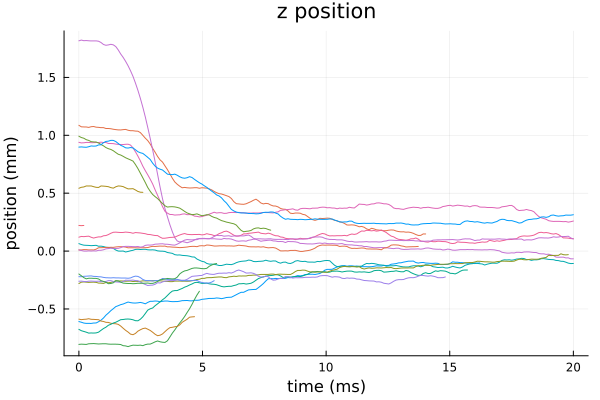

In [8]:
plot_all_trajectories(results, "z")
plot!()

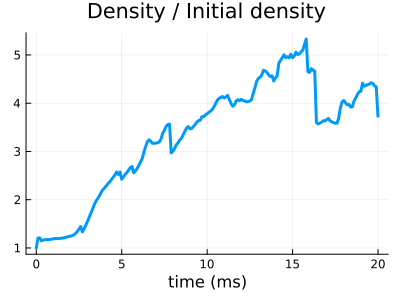

In [11]:
dt = results.times[1][2] - results.times[1][1]
time_plot = LinRange(0, Int(params.t_end*1e3 ÷ dt)*dt, Int(params.t_end*1e3 ÷ dt))
plot(time_plot, [density_gaussian(i, results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories) for i ∈ eachindex(time_plot)]./density_gaussian(1, results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories), linewidth=3 )
plot!(title="Density / Initial density", xlabel="time (ms)", size = (400,300), legend=false)
# savefig("scan7//2freq_optimal_density.png")

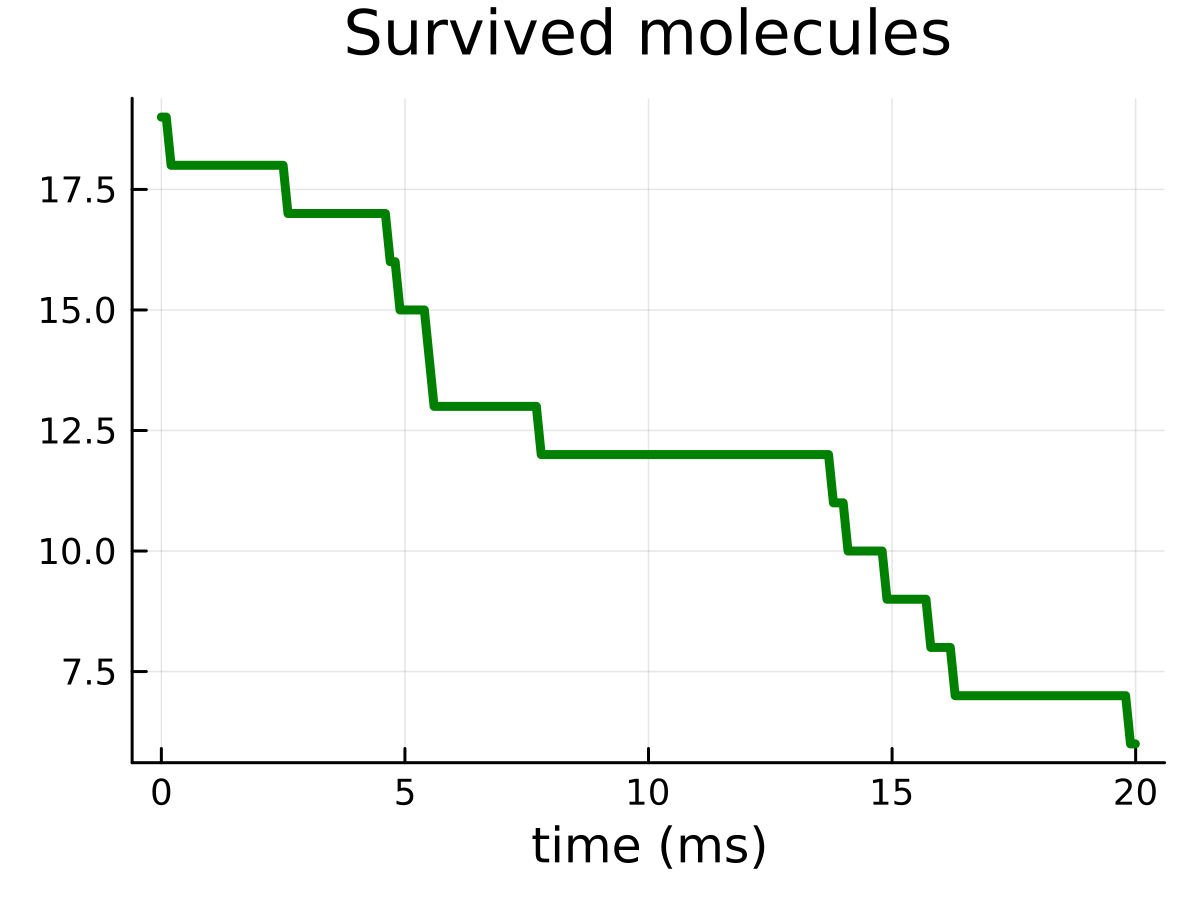

In [15]:
survival = []
dt = results.times[1][2] - results.times[1][1]
for i in 1:Int(params.t_end*1e3 ÷ dt)
    points = get_points_from_results(results, i)
    num = 0
    for p in points
       if p[1]^2 + p[2]^2 + p[3]^2 < (3)^2
            num += 1
        end
    end
    push!(survival, num)
end


time_plot = LinRange(0, Int(params.t_end*1e3 ÷ dt)*dt, Int(params.t_end*1e3 ÷ dt))
plot(time_plot,survival, linewidth=3, color=:green)
plot!(title="Survived molecules", xlabel="time (ms)", size = (400,300), legend = false, dpi=300)
plot!()

In [93]:
function get_trapped_indicies(param, results)
   t_max =  param.t_end*1e3
    trapped_indicies = Int[]
    for i in 1:length(results.times)
        if results.times[i][end] ≈ t_max
           push!(trapped_indicies, i) 
        end
    end
    return trapped_indicies
end

get_trapped_indicies (generic function with 1 method)

In [16]:
function make_2D_image(results, x_min, x_max, n_pixels;t=-1.0)
    it = 1
    if t < 0
        it = results.common_length
    else
       dt = results.times[1][2] - results.times[1][1]
        it = Int(t ÷ dt) + 1
    end
    grids = zeros(n_pixels, n_pixels)
    x = LinRange(x_min, x_max, n_pixels)
    dx = x[2]-x[1]
    z = LinRange(x_min, x_max, n_pixels)
    for i in 1:length(results.times)
        if it > length(results.times[i])
            continue
        end
        x_end = results.x_trajectories[i][it]
        z_end = results.z_trajectories[i][it]
       if  (x_min < x_end < x_max) && (x_min < z_end < x_max)
           ix = Int((x_end - x_min) ÷ dx + 1)
            iz = Int((z_end - x_min) ÷ dx + 1)
            grids[ix, iz] += 1
        end
    end
    return x, z, grids
end

make_2D_image (generic function with 1 method)

## Scan configurations

In [31]:
function next_configuration!(lists, indicies)
   for which_param in 1:length(lists)
       if indicies[which_param] < length(lists[which_param])
           indicies[which_param] += 1
            break
        else # set this param to index q, try to increase the next next param
            indicies[which_param] = 1
        end
    end
end
;

In [96]:
# fixed:
t_end = 10e-3 #s
n_values = 100
ramp_time = 10e-3 #s
B_gradient = -30 #G/cm

temp = @with_unit 0.01 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]


# variable:
pol1_x_list = [σ⁻]
pol2_x_list = [σ⁺]
pol3_x_list = [σ⁻]
pol4_x_list = [σ⁺]

s1_list = [1.0, 2, 3, 4, 5].*(2/3)
s2_list = [0.0]
s3_list = [0.0]
s4_list = [1.0]

Δ4 = (13- 51.0 +51.6)* 2π * 1e6
Δ1_list = [2π*13e6]
Δ2_list = [-0.8Γ]
Δ3_list = [-Γ]
Δ4_list = [Δ4]

lists = [pol1_x_list, pol2_x_list, pol3_x_list, pol4_x_list,
        s1_list, s2_list, s3_list, s4_list,
        Δ1_list, Δ2_list, Δ3_list, Δ4_list]

n_scans = 1
for l in lists
   n_scans *= length(l) 
end

comments = "scan total power]";
saving_dir = make_scan_folder(lists, working_dir, 1, comments);

scan_counter = 0
indicies = [1,1,1,1, 1,1,1,1, 1,1,1,1];

In [97]:
n_scans 

5

In [77]:
# resume scan half-way: 

# scan_counter = 0
# indicies = [1,1,1,1, 1,1,1,1, 1,1,1,1]
# while scan_counter < 126
#     scan_counter += 1
#     next_configuration!(lists, indicies)
# end;

In [98]:
while scan_counter < n_scans
    @printf("============= configuration %i / %i =============", scan_counter+1, n_scans)
    println()
    
    pol1_x = pol1_x_list[indicies[1]]
    pol2_x = pol2_x_list[indicies[2]]
    pol3_x = pol3_x_list[indicies[3]]
    pol4_x = pol4_x_list[indicies[4]]
    s1 = s1_list[indicies[5]]
    s2 = s2_list[indicies[6]]
    s3 = s3_list[indicies[7]]
    # s4 = s4_list[indicies[8]]
    s4 = s1/2
    Δ1 = Δ1_list[indicies[9]]
    Δ2 = Δ2_list[indicies[10]]
    Δ3 = Δ3_list[indicies[11]]
    Δ4 = Δ4_list[indicies[12]]
    
    params = MutableNamedTuple(t_end = t_end, n_values = n_values,
                            pol1_x=pol1_x, pol2_x=pol2_x, pol3_x=pol3_x, pol4_x=pol4_x, 
                            s1=s1, s2=s2, s3=s3, s4=s4,
                            Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                            B_gradient = B_gradient, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = ramp_time)

    test_i = log_test_info(saving_dir,1,params)
    
    results = simulate_particles_v2(package, params);

    save_results(saving_dir, test_i, results)
    
   scan_counter += 1 
   next_configuration!(lists, indicies)

    
end
;

============= configuration 1 / 5 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:39


============= configuration 2 / 5 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:19


============= configuration 3 / 5 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:25


============= configuration 4 / 5 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:47


============= configuration 5 / 5 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:22


In [99]:
scan_i = 7
plots = []
for test_i in 1:5
    params = load_test_params(@sprintf("scan%i", scan_i),test_i)
    results = load_results(@sprintf("scan%i", scan_i),test_i);

    x, z, grids = make_2D_image(results, -2,2,50; t=10.0);
    push!(plots, heatmap(x, z, grids, clim=(0,2)))
    println(sum(grids))
end

# plot!(plots, layout = (2,2), xlabel="z (mm)", ylabel="x (mm)")


79.0
62.0
62.0
59.0
49.0


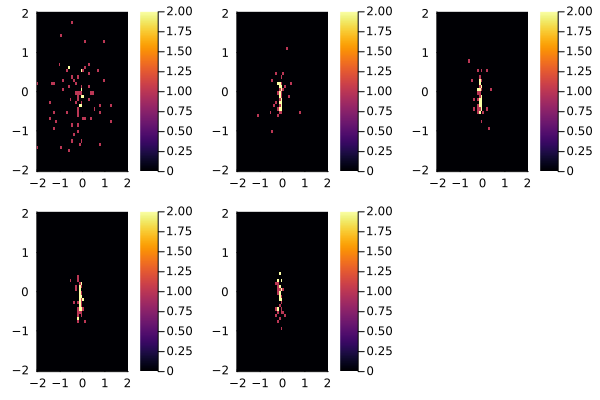

In [100]:
plot(plots[1],plots[2],plots[3],plots[4], plots[5])

In [13]:
function get_points_from_results(results, it)
   points = []
    for i in 1:length(results.times)
        if it < length(results.times[i])
            push!(points, (results.x_trajectories[i][it], results.y_trajectories[i][it],results.z_trajectories[i][it]))
        end
    end
    return points
end

get_points_from_results (generic function with 1 method)

In [368]:
using Plots

results = results1
# Number of frames in the animation
num_frames = 120
saving_dir = "scan7"
# Initialize random points
points = get_points_from_results(results, 1)
dt = results.times[1][2] - results.times[1][1]

# Create a function to update the positions of points in each frame
function update_points(points, num_frames)
    anim = Animation()
    for f in 1:num_frames
        # Update the position of each point randomly
        points = get_points_from_results(results, f)
        
        # Create a 3D scatter plot
        scatter3d([p[1] for p in points], [p[2] for p in points], [p[3] for p in points],
            legend=false, xlim=[-2,2], ylim=[-2,2], zlim=[-2,2], dpi=200)
        
        # Set axis labels
        xlabel!("x (mm)")
        ylabel!("y (mm)")
        zlabel!("z (mm)")
        
        # Set the title for each frame
        title!(@sprintf("t = %.0f ms", f * dt))
        
        frame(anim)
    end
    return anim
end

# Create the animation
animation = update_points(points, num_frames)

# Define the filename and save the animation as an MP4 video
filename = joinpath(saving_dir, "animation_2freq_subopt.mp4")
mp4(animation, filename)

# Alternatively, you can save it as a GIF (may require additional libraries)
# filename = "trajectory_animation.gif"
# gif(animation, filename)

println("Animation saved as $filename")


Animation saved as scan7\animation_2freq_subopt.mp4


[ Info: Saved animation to G:\My Drive\github\OpticalBlochEquations\examples\ipynb_sources\toy_models\CaOH_scan\scan7\animation_2freq_subopt.mp4


In [96]:
results_3freq = results1;

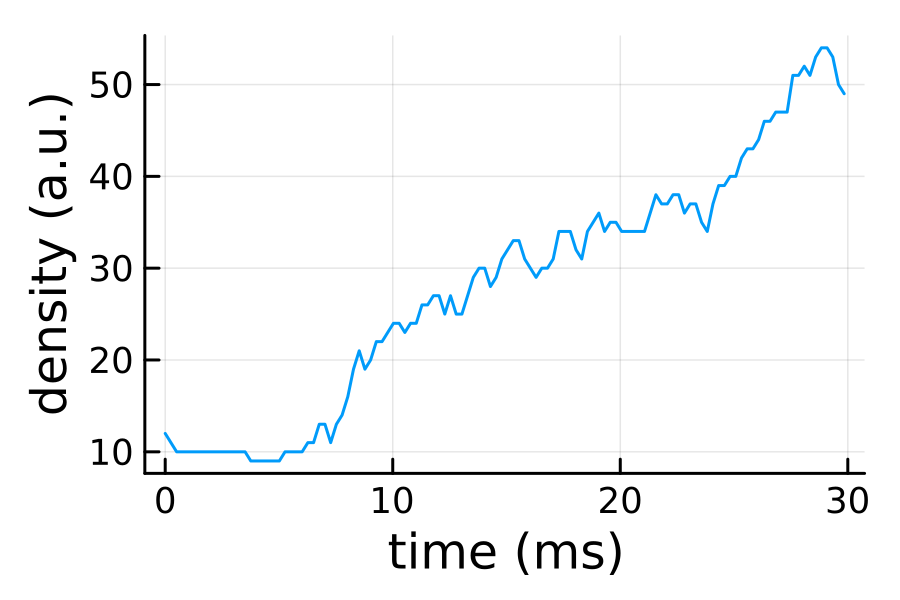

In [102]:
density = []
dt = results_3freq.times[1][2] - results_3freq.times[1][1]
for i in 1:120
    points = get_points_from_results(results_3freq, i)
    num = 0
    for p in points
       if p[1]^2 + p[2]^2 + p[3]^2 < (0.4)^2
            num += 1
        end
    end
    push!(density, num)
end

plot(LinRange(0, 120*dt, 120),density)
plot!(xlabel="time (ms)", ylabel="density (a.u.)", legend=false, size=(300,200), dpi=300)
# savefig("scan7//3freq_density.png")
plot!()

In [98]:
# density = []
# dt = results.times[1][2] - results.times[1][1]
# for i in 1:180
#     points = get_points_from_results(results, i)
#     num = 0
#     for p in points
#        if p[1]^2 + p[2]^2 + p[3]^2 < (0.4)^2
#             num += 1
#         end
#     end
#     push!(density, num)
# end

# plot(LinRange(0, 180*dt, 180),density)
# plot!(xlabel="time (ms)", ylabel="density (a.u.)", legend=false, size=(300,200), dpi=300)
# # savefig("scan7//2freq_density.png")
# plot!()

In [108]:
results_2 = load_results("scan7",1);
results_2.times[1][2]

0.24867959858108646

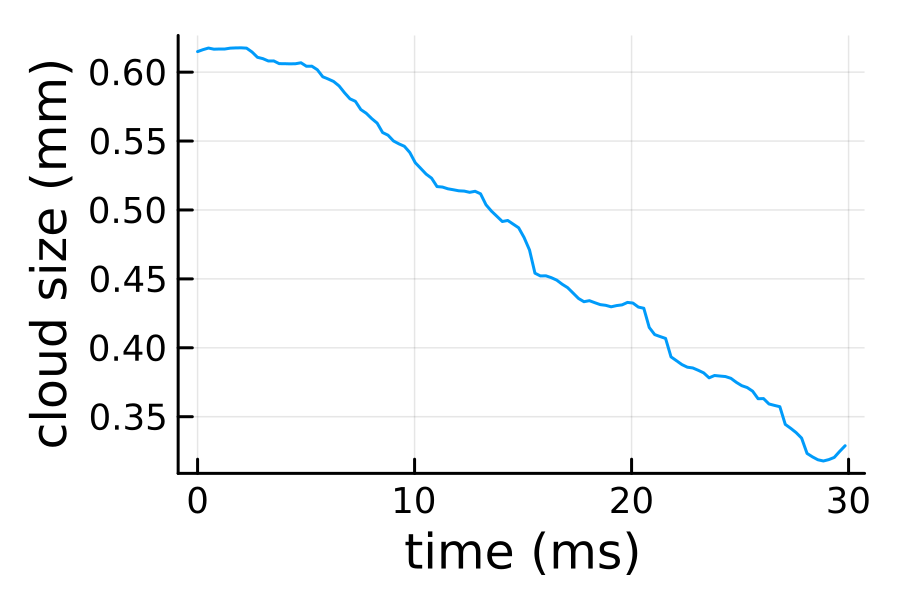

In [113]:
widths = []
dt = results1.times[1][2] - results1.times[1][1]
for i in 1:120
    points = get_points_from_results(results1, i)
    wx = std([p[1] for p in points])
    wy = std([p[2] for p in points])
    wz = std([p[3] for p in points])
    push!(widths, (wx+wy+wz)/3)
end
plot(LinRange(0,120*dt, 120), widths)
plot!(xlabel="time (ms)", ylabel="cloud size (mm)", legend=false, size=(300,200), dpi=300)
# savefig("scan7//2freq_size")
plot!()

In [87]:
params

MutableNamedTuple(t_end = 0.02, n_values = 200, pol1_x = ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], pol2_x = ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], pol3_x = ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], pol4_x = ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], s1 = 2.0, s2 = 0.0, s3 = 0.0, s4 = 1.0, Δ1 = 8.168140899333462e7, Δ2 = -3.2169908772759482e7, Δ3 = -6.635043684381642e7, Δ4 = 8.545132017764239e7, B_gradient = -30, temp = 1.0e-5, diameter = 0.0006, displacement = [0.0, 0.0, 0.0], kick = [0.0, 0.0, 0.0, 0.0], ramp_time = 0.01)